<div class="alert alert-info">
This is an optional supplementary notebook
</div>

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
plt.style.use(["seaborn-deep", "seaborn-whitegrid"])

# The density problem

Similarly to the VAE and GAN, we are interested in capturing some empirical input distribution $p(x)$, for which we observe a dataset of samples $\{ x\}^n_{i=1} \sim p(x)$. Each of the models we have seen have been capable of performing this task, but there are a number of problems with both approaches:

A major weakness of the VAE was that it does not generate "sharp" images even if we average over multiple samples. The reason for this is grounded in the maximisation of the lower bound, which is only a surrogate for the generative quality, as it is heavily penalised by the KL-term.

For GANs we saw sharp images, but many other problems were swept under the rug. Firstly, training GANs is extremely difficult, with the models being prone to mode-collapses and divergence during training. Additionally, the probabilistic framework posited by VAEs, gives us way to measure the probability of a sample under the distribution - this is missing in GANs.

Luckily, another recent technique has shown promise on these fronts. Let us preface the model by considering how one would estimate the density of a random variable under a known transform. If we let $z \sim \mathcal{N}(0, 1)$ and $f(z) = (z/2)^3$ we can plot the resulting density.

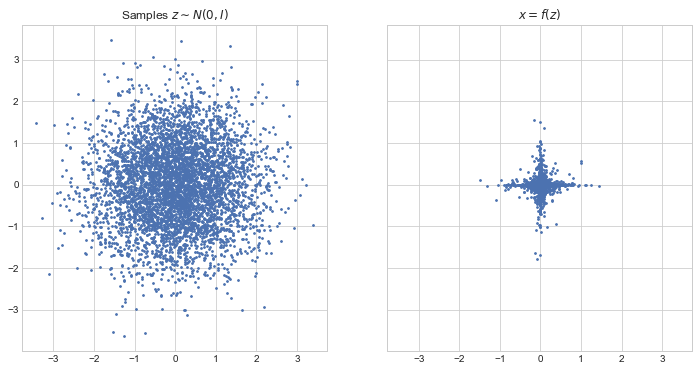

In [2]:
import torch
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

from torch.distributions import Normal

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
n_samples = 5000

# Define the base distribution p(z)
base = Normal(torch.zeros(2), torch.ones(2))
z = base.sample((n_samples,))

ax1.scatter(*z.t(), s=3)
ax1.set_title(r"Samples $z \sim N(0, I)$")
ax1.grid(True)

# Naïvely transform samples
f = lambda z: (z/3)**3
x = f(z)

ax2.scatter(*x.t(), s=3)
ax2.set_title(r"$x = f(z)$")
ax2.grid(True)

plt.show()

A neat trick from probability theory to estimate the density under $f$ is the change of variables formula. For any injective function $f$, we know the following.

$$p(x) = p(z) \left | \det \left( \frac{\partial f(z)^{-1}}{\partial z} \right )\right | = p(z) \left | \det \left(\frac{\partial f(z)}{\partial z} \right ) \right |^{-1}$$

Where $\partial f(z)/\partial z$ represents the Jacobian of the transform. With this in mind we can fully characterise $p(x)$ including sampling and scoring.

---

**Assignment**:

Use the change of variables formula above to compute $p(x)$ analytically knowing that $z$ is a standard bivariate normal distribution and $f(z) = (z/2)^3$. Is $f$ invertible?

**Solution**:

---

Using this formula we can estimate any density as long as we have a known base distribution $p(z)$ and are able to compute the Jacobian matrix of the transform we are interested in. So let us therefore consider a more difficult example seen below. It is known that there exists some function from $z$ to this space, but we do not know *what* it is.

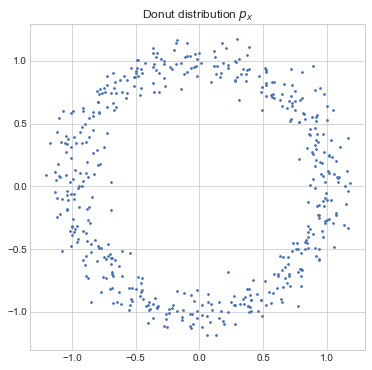

In [3]:
import numpy as np

f = plt.figure(figsize=(6, 6))
n_samples = 500

l = torch.linspace(-np.pi, np.pi, n_samples)
x = torch.stack([torch.cos(l), torch.sin(l)]).t() + 0.1 * torch.randn(n_samples, 2)

plt.scatter(*x.t(), s=3)
plt.title(r"Donut distribution $p_x$")

plt.show()

# Flow models

Most likely, you are at wit's end when it comes to figuring out what $f$ could be in this case, so let us instead use deep learning. The idea is simple, let a neural network act as $f: Z \to X$ and constrain the network such that the Jacobian is tractable. The model class has many different names, but is often referred to as **Flow** models after one of the most popular papers on the subject, *normalizing flows* [[Rezende & Mohamed, 2015]](https://arxiv.org/abs/1505.05770), though the idea is much older.

In the paper they solve the problem by making a neural network consisting of layers of invertible transformations for which the determinant of the Jacobian can be computed in linear time. The exact formulation of these flows is very cumbersome and the implementation slow, so we will instead work on the model described by [[Dinh, 2016]](https://arxiv.org/abs/1605.08803).

## Coupling Layers

Coupling layers proposed in [[Dinh, 2014]](https://arxiv.org/abs/1410.8516) provides a principled way of computing the determinant of the Jacobian in linear time by making the layer itself invertible. The layer splits the input into two streams and perform a translation and scaling of one stream, the other stays constant. Because one stream is unchanged, the Jacobian will be triangular.

*Forward propagation* through the layer is shown below.

<img src="https://hci.iwr.uni-heidelberg.de/vislearn/wp-content/uploads/2018/07/INN-coupling-layer.png" alt="Coupling layer" width="500px">

*Inverse propagation* through the layer is simple equally simple.

<img src="https://hci.iwr.uni-heidelberg.de/vislearn/wp-content/uploads/2018/07/INN-coupling-layer-inverse.png" alt="Coupling layer inverse" width="500px">

Here are some quick facts about the layer to motivate its use.

* The Jacobian is lower-triangular, therefore the determinant is given as the product of the diagonal elements $\prod_{i=1}^d s_i$.
* Layer stacking is trivial due to the identity $\det(AB) = \det(A)\det(B)$.
* The inner neural modules (s, t) can be arbitrarily complex
* $f$ must be bijective, so it is required that $dim(X) = dim(Z)$.

In [4]:
from torch import nn

class AffineCoupling(nn.Module):
    """
    Affine coupling layer described in "RealNVP" [Dinh et al, 2016]
    
    A mask is used to split the streams
    """
    def __init__(self, in_features, hidden_features=256):
        super(AffineCoupling, self).__init__()

        self.scale = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, in_features),
        )
        
        self.translate = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, in_features)
        )
        
    def forward(self, x, mask=None):
        """
        Forward propagation (inference) y = f(x) = x1 + (x2 * s(x1) + t(x1))
        """ 
        x_ = mask * x

        s = self.scale(x_) * (1 - mask)
        t = self.translate(x_) * (1 - mask)

        y = x_ + (1 - mask) * (x * torch.exp(s) + t)
        jacobian = torch.sum(s, -1, keepdim=True)
        
        return y, jacobian

    def inverse(self, y, mask=None):
        """
        Inverse propagation (generation) x = f^(-1)(y) = y1 + (y2 - t(y1)) / s(y1))
        """
        y_ = mask * y

        s = self.scale(y_) * (1 - mask)
        t = self.translate(y_) * (1 - mask)

        x = y_ + (1 - mask) * ((y - t) * torch.exp(-s))
        jacobian = torch.sum(s, -1, keepdim=True)

        return x, jacobian

In [5]:
class RealNVP(nn.Module):
    """
    Real non-volume preserving network (RealNVP)
    is just a stack of affine coupling layers.
    """
    def __init__(self, in_features, hidden_features=256, depth=6):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([AffineCoupling(in_features, hidden_features) for _ in range(depth)])
        
        # A binary mask is used to make splitting of streams simple
        base_mask = torch.FloatTensor([[0, 1]])
        self.mask = nn.Parameter(base_mask.repeat((depth, 1)), requires_grad=False)
        
        # Alternate masking
        indices = [i for i in range(depth) if i%2]
        self.mask[indices] = 1 - self.mask[indices]
        
    def forward(self, x):
        """
        Forward propagation (inference) y = f(x)
        
        Gather the jacobian, log det(ab) = log det(a) + log det(b)
        """
        jacobian = torch.zeros_like(x)
        for mask, layer in zip(self.mask, self.layers):
            x, log_det_J = layer.forward(x, mask)
            jacobian += log_det_J
        
        return x, jacobian
    
    def inverse(self, y):
        """
        Inverse propagation (generation) x = f^(-1)(y)
        """
        jacobian = torch.zeros_like(y)
        # Run the operation in reverse
        for mask, layer in zip(reversed(self.mask), reversed(self.layers)):
            y, log_det_J = layer.inverse(y, mask)
            jacobian -= log_det_J

        return y, jacobian

In [6]:
# Define the base distribution and its parameters
mu = torch.zeros(2).to(device)
sigma = torch.ones(2).to(device)
base = Normal(mu, sigma)

# The RealNVP model is a stack of identical coupling layers, here we use 6 couplng layers.
model = RealNVP(in_features=2, hidden_features=256, depth=6).to(device)
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

As a loss function we can simply resort to maximum likelihood, or equivalently, minimising the negative log likelihood.

$$-\max_\theta \log p(x) = -\log p(z) - \log \left | \det \left( \frac{\partial f_{\theta}(z)^{-1}}{\partial z} \right ) \right |$$

Below you will see how the network learns both forward and inverse propagation, making it able to generate data from both the latent distribution and the input distribution.

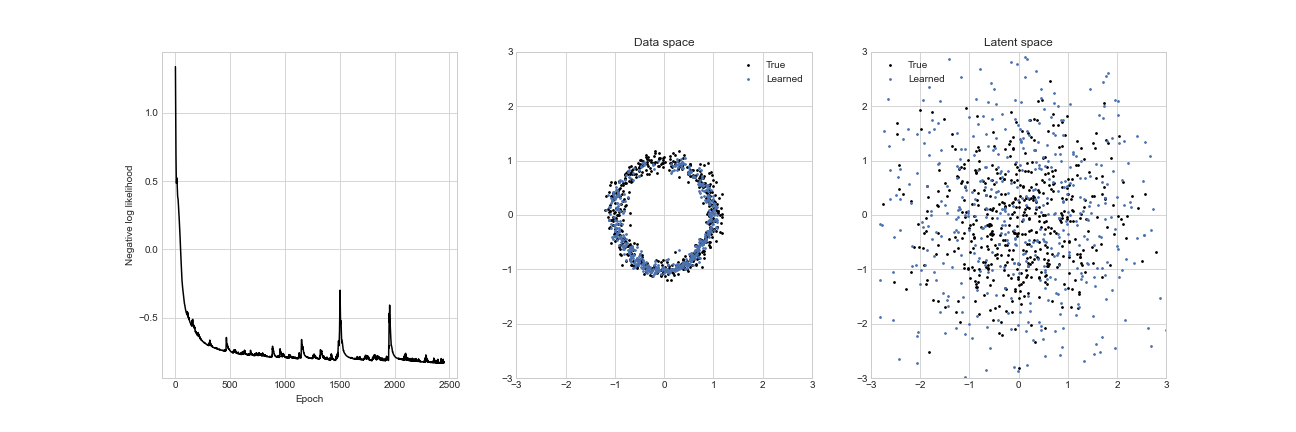

In [7]:
import os

tmp_img = "tmp_nvp_out.png"
losses = []

x = x.to(device)

for epoch in range(2500):
    z, log_det_J = model(x)
    
    # Loss function
    loss = -torch.mean(base.log_prob(z) + log_det_J)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    losses.append(loss.item())
    
    # -- Plotting --
    if epoch % 50 == 0:
        with torch.no_grad():
            z = base.sample((n_samples,))
            z_hat, _ = model.forward(x)
            x_hat, _ = model.inverse(z)
        
        f, axarr = plt.subplots(1, 3, figsize=(18, 6))

        # Loss
        ax = axarr[0]
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Negative log likelihood')
        ax.plot(np.arange(epoch+1), losses, color="black")

        # Data space
        ax = axarr[1]
        ax.set_title("Data space")
        ax.scatter(*x.data.cpu().t(), s=3, c="k", label="True")
        ax.scatter(*x_hat.data.cpu().t(), s=3, label="Learned")
        ax.legend()
        ax.set_xlim([-3, 3]); ax.set_ylim([-3, 3])

        # Latent space
        ax = axarr[2]
        ax.set_title("Latent space")
        ax.scatter(*z.data.cpu().t(), s=3, c="k", label="True")
        ax.scatter(*z_hat.data.cpu().t(), s=3, label="Learned")
        ax.legend()
        ax.set_xlim([-3, 3]); ax.set_ylim([-3, 3])

        plt.savefig(tmp_img)
        plt.close(f)
        display(Image(filename=tmp_img))
        clear_output(wait=True)

        os.remove(tmp_img)

**Assignment**:
    
Experiment with the model. How many affine layers and total neurons do we need to solve this problem? *Hint: You can use the code block below to calculate this number.*

**Solution**:

In [8]:
print("Total neurons:", sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad]))

Total neurons: 804888


**What is possible with this class of models? To get the answer have a look at [OpenAI's](https://blog.openai.com/glow/) recent blog post on the subject.**

In this week we have now discussed all of the current major directions within generative modelling with the exception of autoregressive models. If you are interested in understanding these, please look into models such as PixelCNN and Wavenet. The following table is originally by Laurent Dinh and is a good place to start when comparing the different approaches to deep generative modelling.

|-|Autoregressive|Variational Autoencoders|Generative Adversarial Networks|Flows|
|-|--------------|---|---|---|
|Objective|log-likelihood (stable)|doubly stochastic ELBO (stable)|approximate adversarial loss (unstable)|log-likelihood (stable)|
|Latent space|None|dimension collapsing|low dimensional|high-dimensional|
|Architecture|requires ordering, arbitrary data|arbitrary|arbitrary, continuous data|requires partitioning (NVP), continuous data|